In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

import xgboost as xgb

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
path_to_dataset_folder = "E:\Work\ML\Databases\csv_files\house-prices-advanced-dataset"
train_file = "train.csv"

df_train = pd.read_csv(path_to_dataset_folder+"\\"+train_file)

In [3]:
df_train.shape

(1460, 81)

In [4]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# General Analysis of the interest variable

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


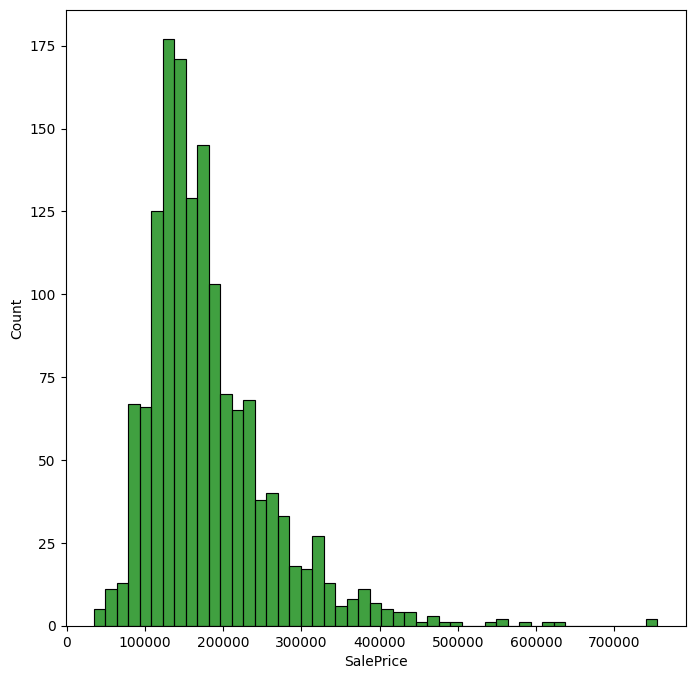

In [5]:
print(df_train['SalePrice'].describe())
plt.figure(figsize=(8, 8))
sns.histplot(df_train['SalePrice'], color='g')
plt.show()
# sns.distplot(df_train['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4})
# plt.show()

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
list(set(df_train.dtypes.tolist()))

[dtype('float64'), dtype('O'), dtype('int64')]

In [8]:
df_train_num = df_train.select_dtypes(include = ['float64', 'int64'])
df_train_num.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


In [9]:
df_train_num.shape

(1460, 38)

<Axes: >

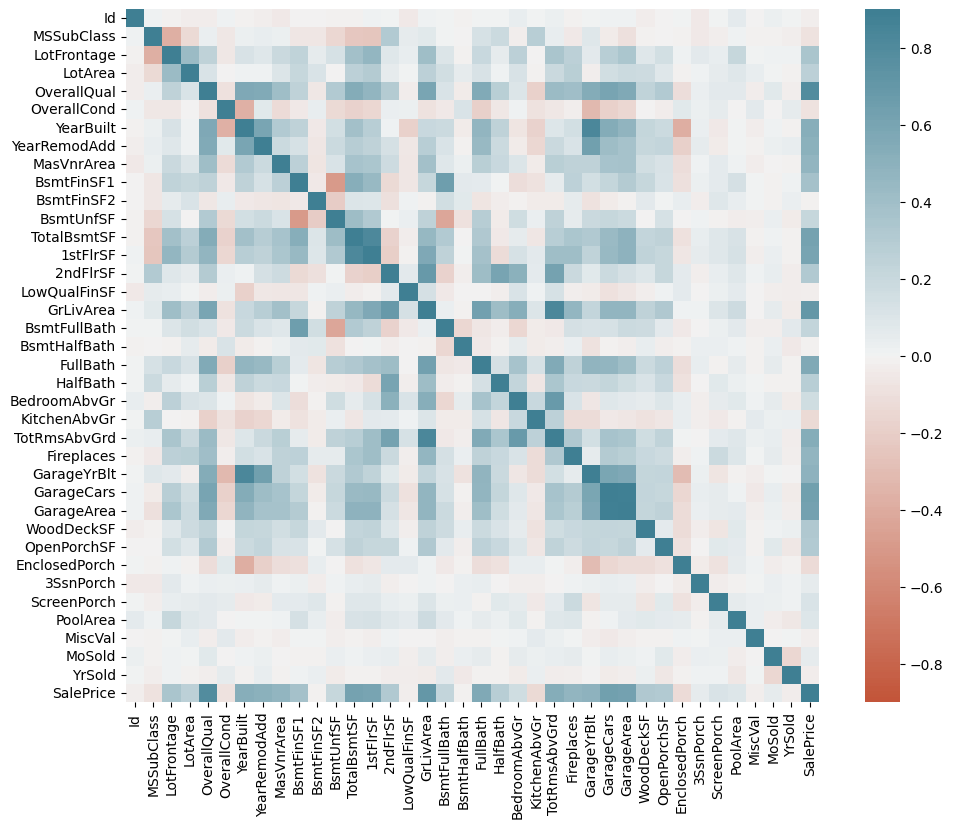

In [10]:
# Correlation matrix to get a big overview of our vars. Useful to discard apparent useless variables
corrmat = df_train_num.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=0.9, vmin=-0.9, center=0, square=True, cmap=sns.diverging_palette(20, 220, n=200),)

In [11]:
corrmat.head().index

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual'], dtype='object')

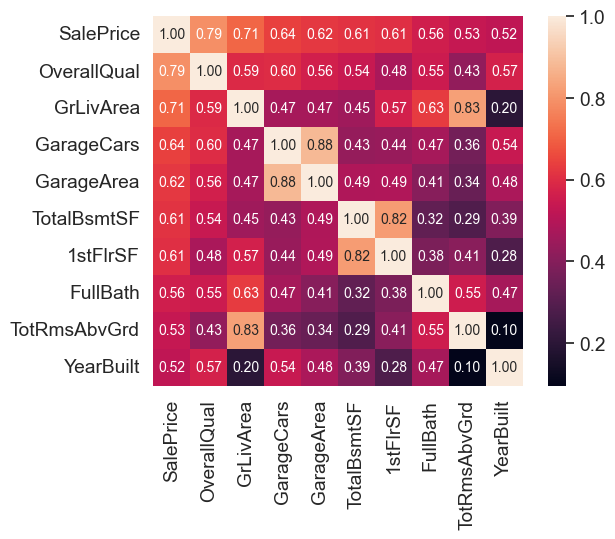

In [12]:
# Keep variables with the biggest cor value

k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

We can see that these are the most correlated vars with the target variable. However, some are very correlated between themselves, so we'll be keeping only 1(ie: GarageCars instead of it & GarageArea, TotalBsmtSF instead of it and 1stFlrSF, GrLivArea instead of 'TotRmsAbvGrd' and 'GrLivArea')

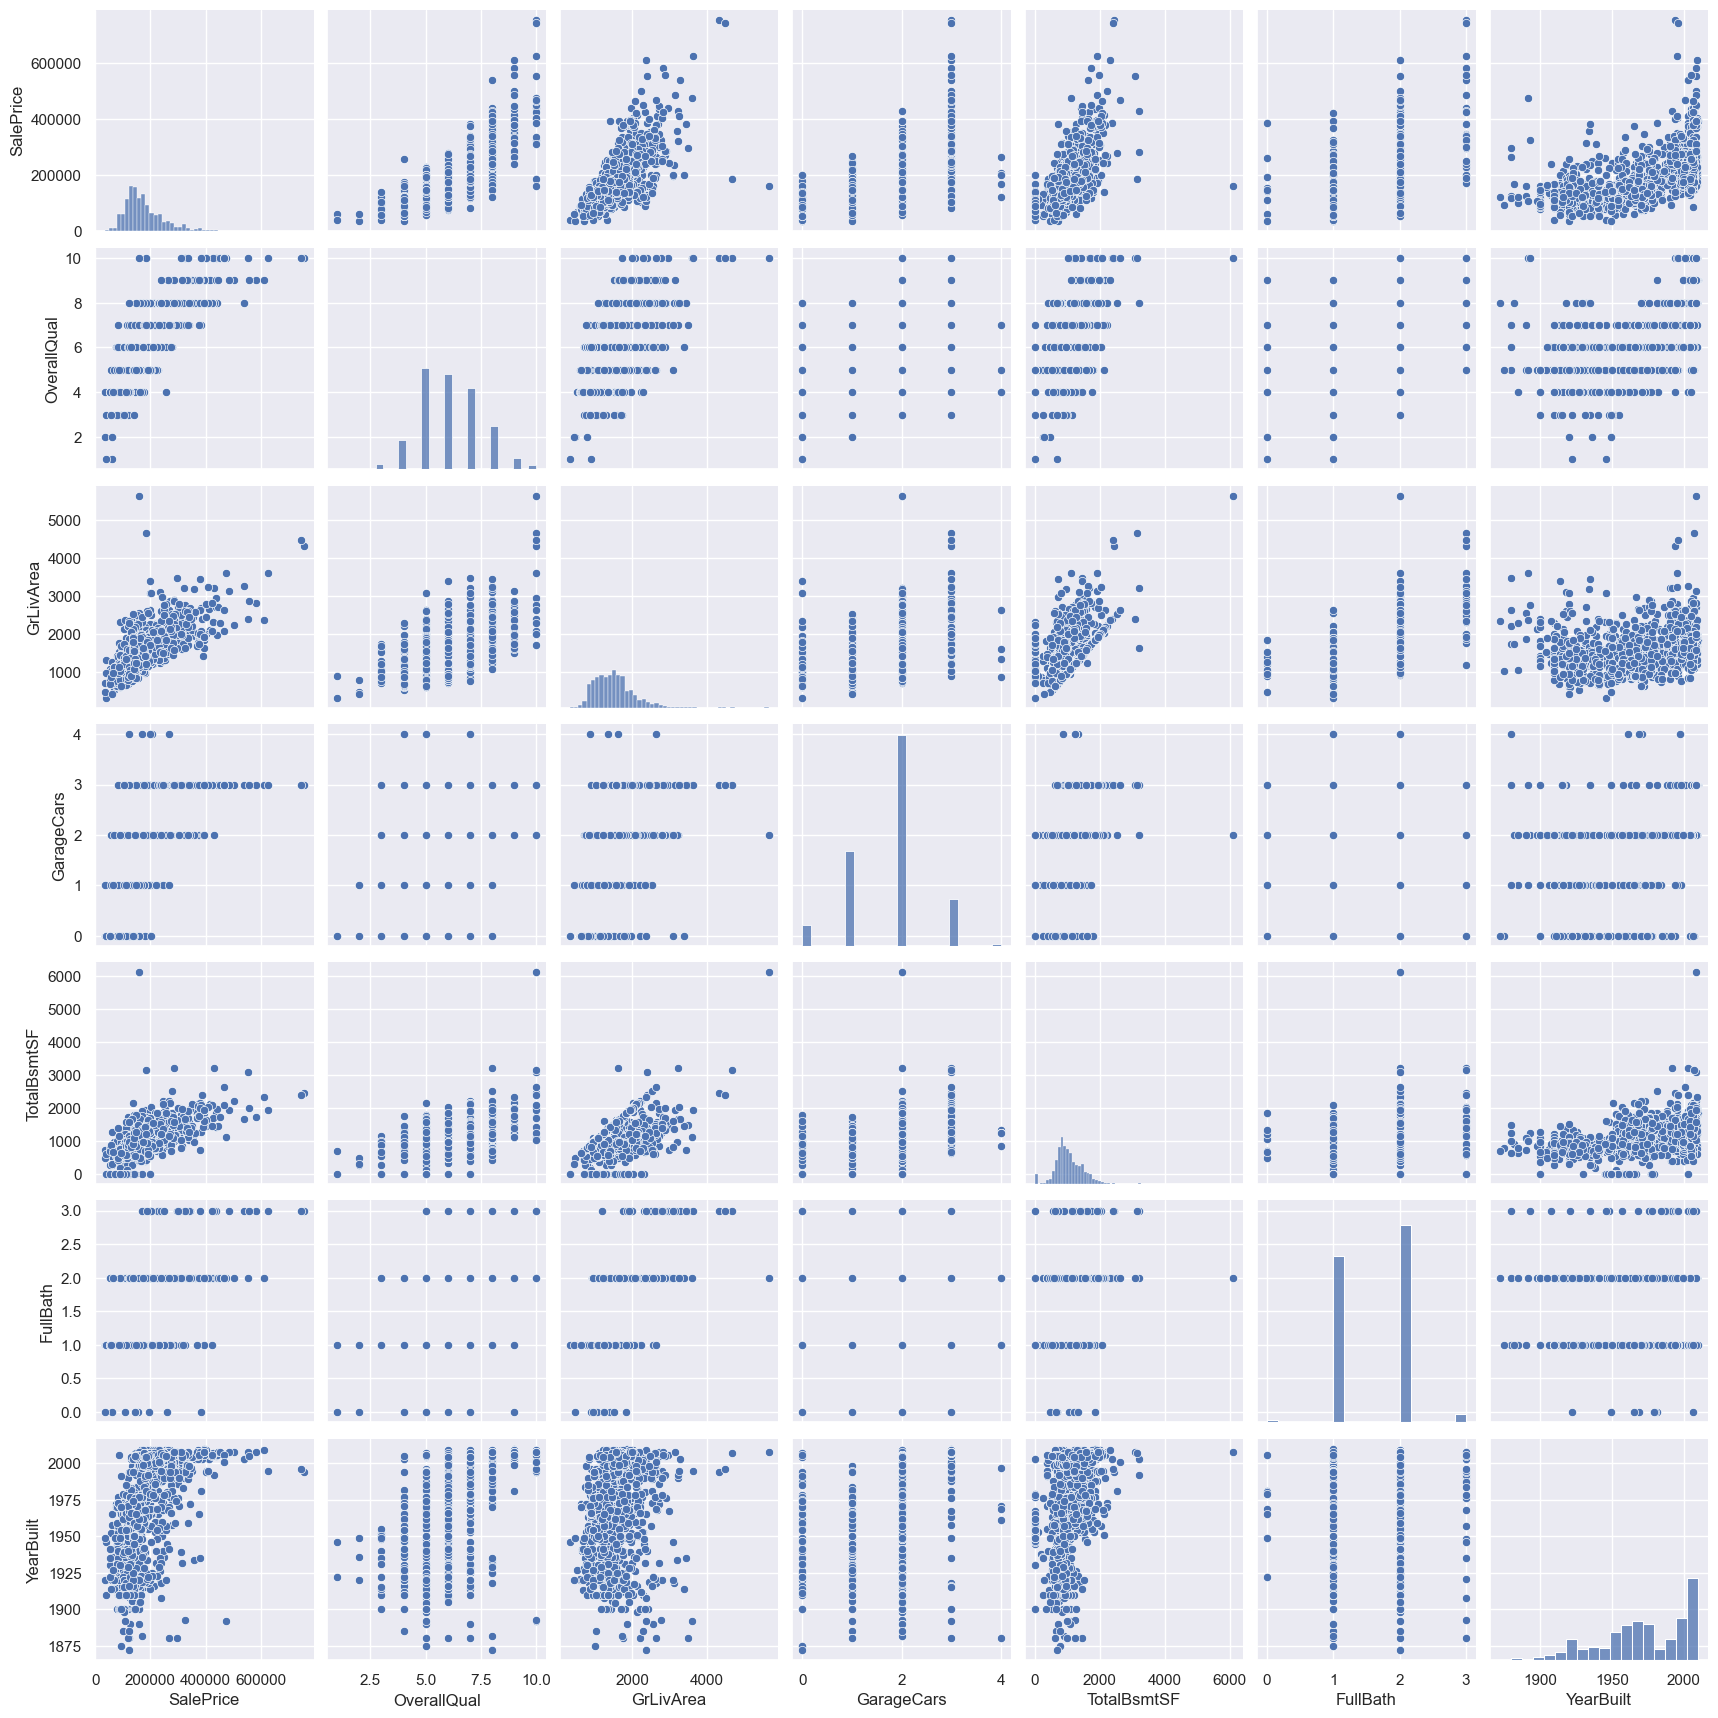

In [13]:
#scatterplot
sns.set_theme()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train_num[cols], height= 2.5)
plt.show()

# Missing Values

In [14]:
# To detect empty elements
na_columns = []
for column in df_train:
    num_elts_in_col = df_train[column].isna().sum()
    if num_elts_in_col > 0 :
        print(f"Column {column} has {num_elts_in_col} empty elements. Column Empty elements percentage: {round(num_elts_in_col*100/df_train.shape[0], 2)}")
        na_columns.append(column)

Column LotFrontage has 259 empty elements. Column Empty elements percentage: 17.74
Column Alley has 1369 empty elements. Column Empty elements percentage: 93.77
Column MasVnrType has 872 empty elements. Column Empty elements percentage: 59.73
Column MasVnrArea has 8 empty elements. Column Empty elements percentage: 0.55
Column BsmtQual has 37 empty elements. Column Empty elements percentage: 2.53
Column BsmtCond has 37 empty elements. Column Empty elements percentage: 2.53
Column BsmtExposure has 38 empty elements. Column Empty elements percentage: 2.6
Column BsmtFinType1 has 37 empty elements. Column Empty elements percentage: 2.53
Column BsmtFinType2 has 38 empty elements. Column Empty elements percentage: 2.6
Column Electrical has 1 empty elements. Column Empty elements percentage: 0.07
Column FireplaceQu has 690 empty elements. Column Empty elements percentage: 47.26
Column GarageType has 81 empty elements. Column Empty elements percentage: 5.55
Column GarageYrBlt has 81 empty elem

In [15]:
# Another way to do it:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
MasVnrType,872,0.597260
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479


Notes on column having NA

From all these columns, the following columns missing elements(having NA) actually has sense:
 - Alley: Means no Alley
 - MasVnrType: Means no Masonnery Vn
 - FireplaceQu: Means no Fireplace
 - GarageType, GarageYrBlt, GarageFinish, GarageQual, GarageCond: Means No garage. Consistent all along the columns.
 - PoolQC: Means no pool
 - Fence: Means no fence
 - MiscFeature: Means house no additional miscellaneous feature not covered above

While the following columns having NA shouldn't make sense(or is not consistent) and MUST be investigated and treated:
 - LotFrontage: A number, we will see what to do
 - MasVnrArea: A number, MasVnArea should be 0 where MasVnType is NA and so the empty values should be investigated and treated
 - BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2 : A Categorical field, so not easy to treat Means no basement. (They should however all have the same number of NAs. The difference in number of NAs should be investigated and that value might have to be replaced or the line removed)
 - Electrical: A categorical field. Has only one missing value, should be an error. Observation can be removed without big impact

Now, before replacing the missing values, we should think about the impact of the variables concerned. If most of them don't matter that much and so can actually be removed without losing too much information, you can just remove them.
Also, when there is too much information lacking, we might as well remove the variable as once because it brings close to no information.
We will however investigate some of these cases just to know what happened and to exercice ourserves a little

## Handling missing values

In [16]:
# To get NAs of MasVnrArea
indices_of_na_values = df_train[df_train['MasVnrArea'].isnull()].index.tolist()
len(indices_of_na_values)

8

In [17]:
# Check Whether NA of MasVnrArea matches with NA of MasVnrType
    
df_train.loc[indices_of_na_values,["MasVnrArea", "MasVnrType"]]

,MasVnrArea,MasVnrType
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


NA values of MasVnrArea match NA values of Mas MasVnrType. We could just replace them by zeros. 

In [18]:
# To get NAs of BsmtExposure & Co.
indices_of_na_values = df_train[df_train['BsmtExposure'].isnull() | df_train['BsmtFinType2'].isnull()].index.tolist()
len(indices_of_na_values)

39

In [19]:
df_train.loc[indices_of_na_values,["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]].head(8)

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
17,NaN,NaN,NaN,NaN,NaN
39,NaN,NaN,NaN,NaN,NaN
90,NaN,NaN,NaN,NaN,NaN
102,NaN,NaN,NaN,NaN,NaN
156,NaN,NaN,NaN,NaN,NaN
182,NaN,NaN,NaN,NaN,NaN
259,NaN,NaN,NaN,NaN,NaN
332,Gd,TA,No,GLQ,NaN


In [20]:
for i in indices_of_na_values:
    if type(df_train.loc[i,"BsmtQual"]) != float:
        print(df_train.loc[i,["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinSF1", "BsmtFinType2", "BsmtFinSF2"]],"\n")

BsmtQual          Gd
BsmtCond          TA
BsmtExposure      No
BsmtFinType1     GLQ
BsmtFinSF1      1124
BsmtFinType2     NaN
BsmtFinSF2       479
Name: 332, dtype: object 

BsmtQual         Gd
BsmtCond         TA
BsmtExposure    NaN
BsmtFinType1    Unf
BsmtFinSF1        0
BsmtFinType2    Unf
BsmtFinSF2        0
Name: 948, dtype: object 



For both BsmtExposure and BsmtFinType2 being nan and not the rest, that's just a mistake in the data as only one row of each ahs that error, since they're categorical vars, we'll see what to do.

In [21]:
df_train["Electrical"].mode()[0], df_train["BsmtExposure"].mode()[0], df_train["BsmtFinType2"].mode()[0]

('SBrkr', 'No', 'Unf')

In [22]:
# New dataset with transformations
new_df_train = df_train.copy()

# Summary of Imputations
- For variables lacking only one value, we can replace by the Nan by the mode or we can use KNNImputer to impute the value and replace it by the one with the 10 nearest neighbours. Anything that doesn't remove data should do the trick as missing values here are very minimal and will have an extremely small impact on the whole dataset(classifier) (i.e. Basement & Co., Electrical)
- For MasVnrArea, that was likely just an error and the correct value should be 0 becaus it has no MasVnr. So we will replace all NAs with 0.
- For Variables where this makes sense, we might just create another category out of it and use it as a different category
- For Lot Frontage, we'll likely use kNN Imputer or Random tree Classifier to try to predict those values as they too many to ignore

In [23]:
# This will be to handle na_values for LotFrontage
new_df_train["LotFrontage"] = df_train.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

# This will be to handle na_values for MasVnrArea
new_df_train["MasVnrArea"] = new_df_train["MasVnrArea"].fillna(0)

# This will be to handle na_values for Basement
new_df_train["BsmtExposure"] = df_train["BsmtExposure"].fillna(df_train["BsmtExposure"].mode()[0])
new_df_train["BsmtFinType2"] = df_train["BsmtFinType2"].fillna(df_train["BsmtFinType2"].mode()[0])

# # This will be to handle na_values for Electrical
new_df_train["Electrical"] = df_train["Electrical"].fillna(df_train["Electrical"].mode()[0])
# Or to drop the observation
# new_df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index, inplace=True)

In [24]:
new_df_train["PoolQC"] = new_df_train["PoolQC"].fillna("None")

new_df_train["MiscFeature"] = new_df_train["MiscFeature"].fillna("None")

new_df_train["Alley"] = new_df_train["Alley"].fillna("None")

new_df_train["Fence"] = new_df_train["Fence"].fillna("None")

new_df_train["FireplaceQu"] = new_df_train["FireplaceQu"].fillna("None")

new_df_train["MasVnrType"] = new_df_train["MasVnrType"].fillna("None")


In [25]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    new_df_train[col] = new_df_train[col].fillna(0)

In [26]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtFinType1'):
    new_df_train[col] = new_df_train[col].fillna('None')

In [27]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    new_df_train[col] = new_df_train[col].fillna('None')

In [28]:
new_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [29]:
# dealing with missing data
# new_df_train.drop((missing_data[missing_data['Total'] > 1]).index,axis=1,inplace=True)

new_df_train.isnull().sum().max() #just checking that there's no missing data missing...

0

# Handling Outliers

In [30]:
saleprice_scaled = StandardScaler().fit_transform(new_df_train['SalePrice'].values[:,np.newaxis])
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83870376]
 [-1.83352844]
 [-1.80092766]
 [-1.78329881]
 [-1.77448439]
 [-1.62337999]
 [-1.61708398]
 [-1.58560389]
 [-1.58560389]
 [-1.5731    ]]

outer range (high) of the distribution:
[[3.82897043]
 [4.04098249]
 [4.49634819]
 [4.71041276]
 [4.73032076]
 [5.06214602]
 [5.42383959]
 [5.59185509]
 [7.10289909]
 [7.22881942]]


Redoing A bivariate analysis

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

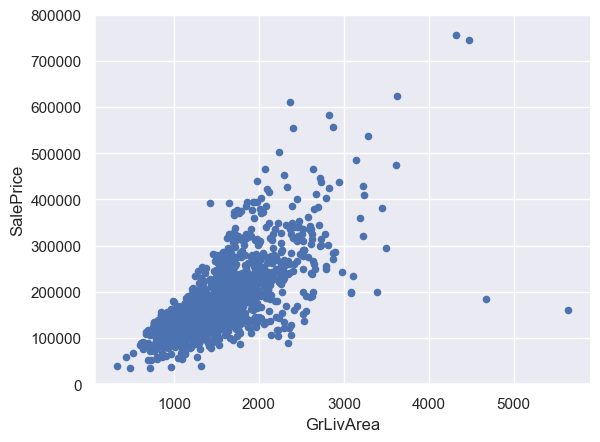

In [31]:
var = 'GrLivArea'
df_train[['SalePrice',var]].plot.scatter(x=var, y='SalePrice', ylim=(0,800000))

In [32]:
# # deleting points (Outliers)
# new_df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]
# new_df_train.drop(new_df_train[df_train['Id'] == 1299].index, inplace=True)
# new_df_train.drop(new_df_train[df_train['Id'] == 524].index, inplace=True)

<Axes: xlabel='TotalBsmtSF', ylabel='SalePrice'>

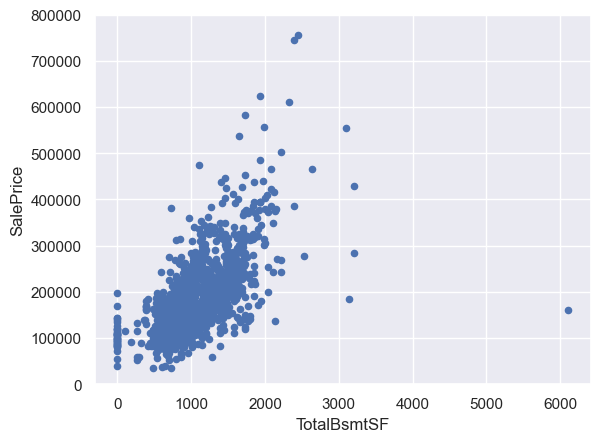

In [33]:
var = 'TotalBsmtSF'
df_train[['SalePrice',var]].plot.scatter(x=var, y='SalePrice', ylim=(0,800000))

# Studying normality

Cf plot of output var distribution up in the file

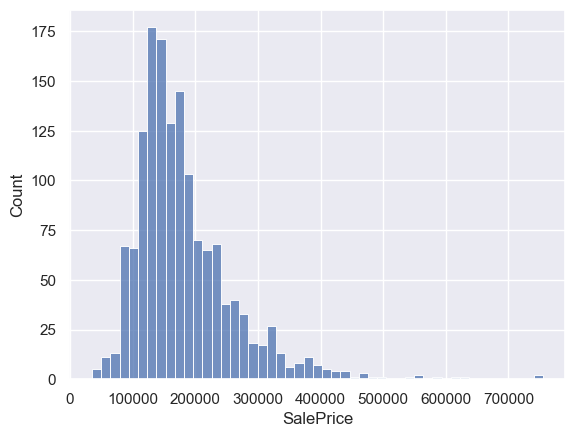

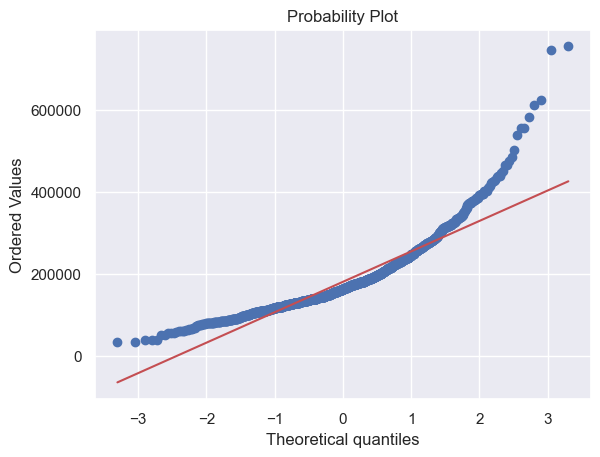

In [34]:
sns.histplot(new_df_train['SalePrice'])
fig = plt.figure()
res = stats.probplot(new_df_train['SalePrice'], plot=plt)

In [35]:
new_df_train['SalePrice'] = np.log(new_df_train['SalePrice'])

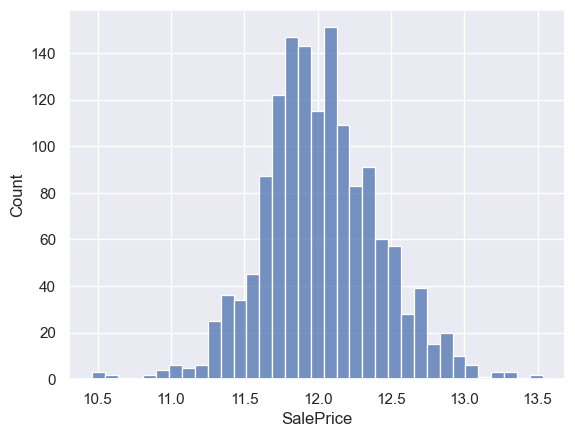

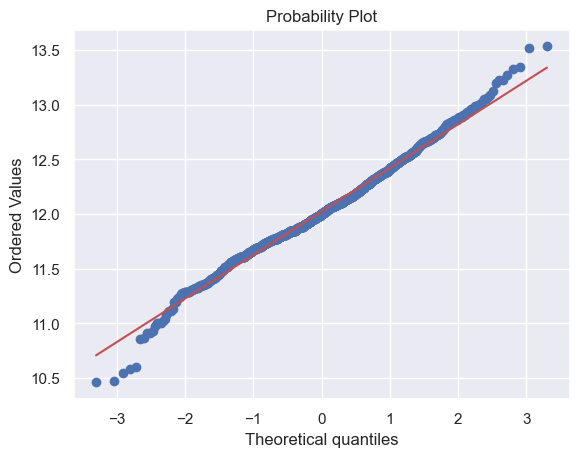

In [36]:
sns.histplot(new_df_train['SalePrice'])
fig = plt.figure()
res = stats.probplot(new_df_train['SalePrice'], plot=plt)

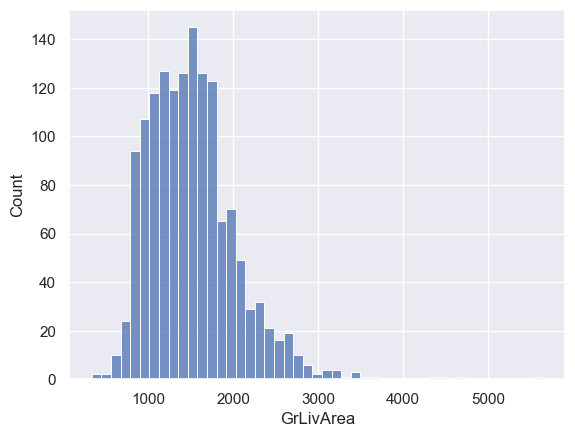

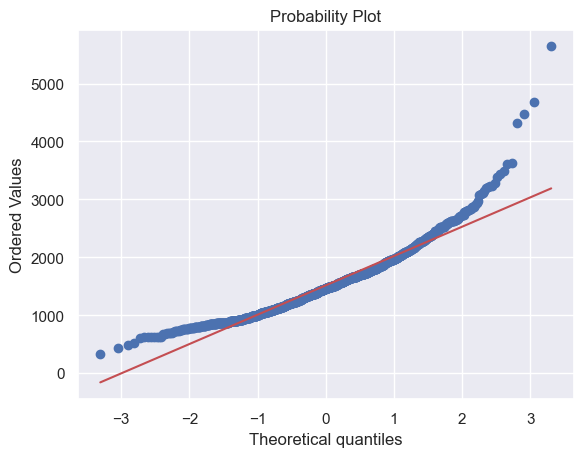

In [37]:
#histogram and normal probability plot
sns.histplot(new_df_train['GrLivArea'])
fig = plt.figure()
res = stats.probplot(new_df_train['GrLivArea'], plot=plt)

In [38]:
#data transformation
new_df_train['GrLivArea'] = np.log(new_df_train['GrLivArea'])

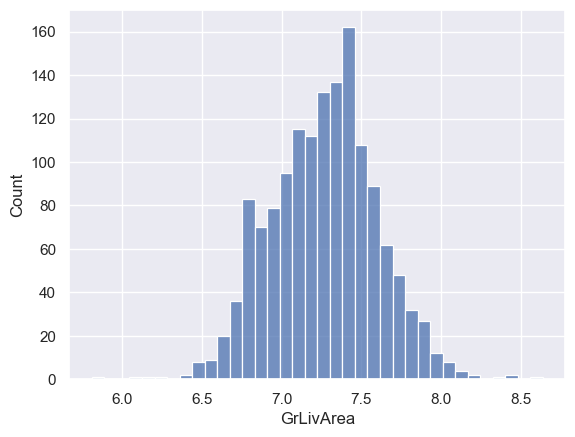

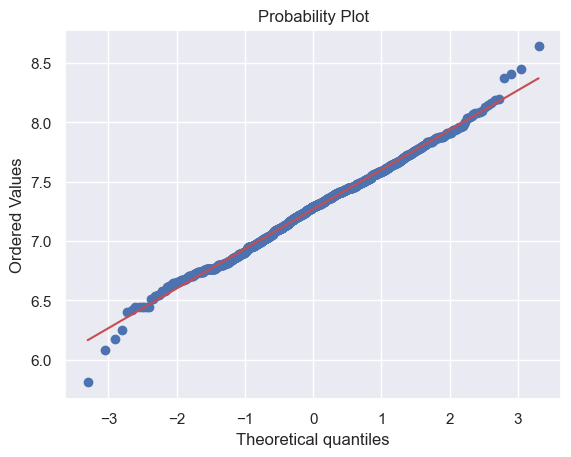

In [39]:
#transformed histogram and normal probability plot
sns.histplot(new_df_train['GrLivArea'])
fig = plt.figure()
res = stats.probplot(new_df_train['GrLivArea'], plot=plt)

Careful about what is coming

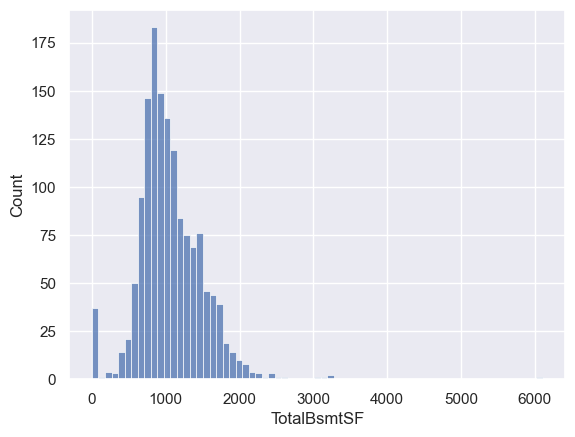

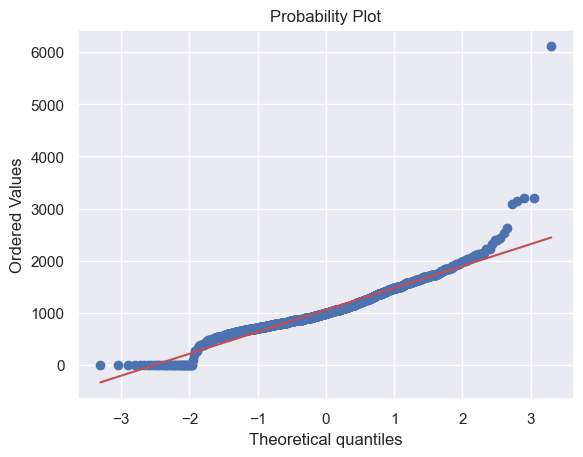

In [40]:
sns.histplot(new_df_train['TotalBsmtSF'])
fig = plt.figure()
res = stats.probplot(new_df_train['TotalBsmtSF'], plot=plt)

Ok, now we are dealing with the big boss. What do we have here?

- Something that, in general, presents skewness.
- A significant number of observations with value zero (houses without basement).
- A big problem because the value zero doesn't allow us to do log transformations.

To apply a log transformation here, we'll create a variable that can get the effect of having or not having basement (binary variable). Then, we'll do a log transformation to all the non-zero observations, ignoring those with value zero. This way we can transform data, without losing the effect of having or not basement.

I'm not sure if this approach is correct. It just seemed right to me. That's what I call 'high risk engineering'.

In [41]:
# create column for new variable (one is enough because it's a binary categorical feature)
# if area>0 it gets 1, for area==0 it gets 0
new_df_train['HasBsmt'] = pd.Series(len(new_df_train['TotalBsmtSF']), index=new_df_train.index)
new_df_train['HasBsmt'] = 0 
new_df_train.loc[new_df_train['TotalBsmtSF']>0,'HasBsmt'] = 1

In [42]:
# transform data
new_df_train.loc[new_df_train['HasBsmt']==1,'TotalBsmtSF'] = np.log(new_df_train['TotalBsmtSF'])

e:\Work\ML\models\ml_practise\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\TOUOMOU FABRICE\AppData\Local\Temp\ipykernel_6228\1359611479.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[6.75227038 7.14045304 6.82437367 ... 7.04925484 6.98286275 7.13568735]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_df_train.loc[new_df_train['HasBsmt']==1,'TotalBsmtSF'] = np.log(new_df_train['TotalBsmtSF'])


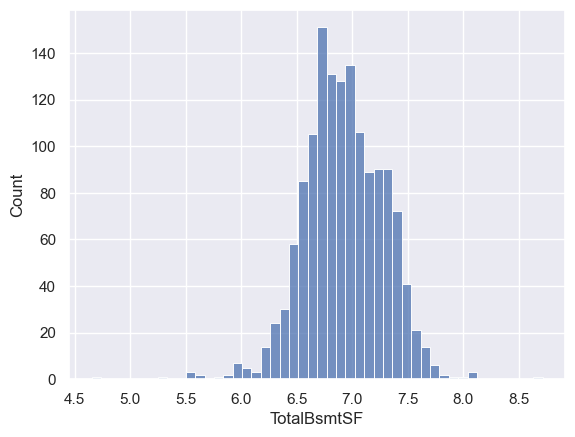

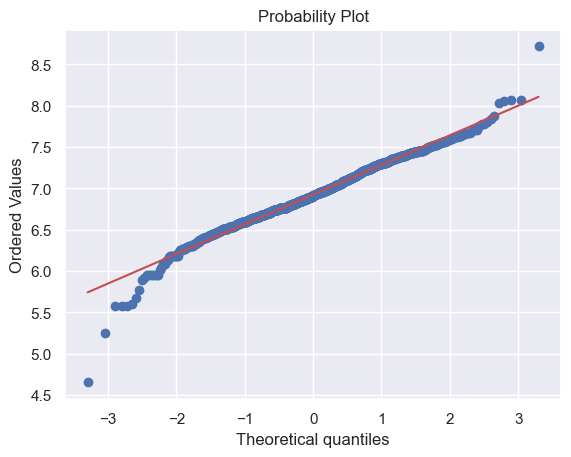

In [43]:
# histogram and normal probability plot
sns.histplot(new_df_train[new_df_train['TotalBsmtSF']>0]['TotalBsmtSF'])
fig = plt.figure()
res = stats.probplot(new_df_train[new_df_train['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

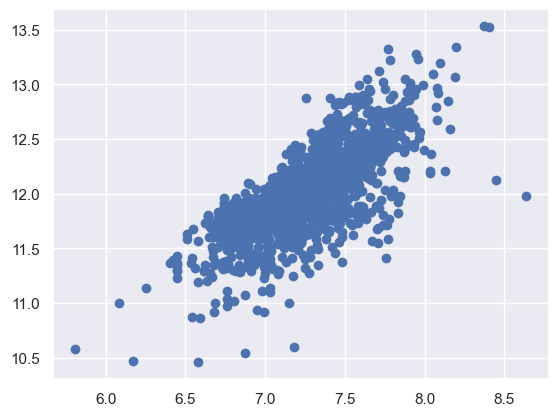

In [44]:
# scatter plot
plt.scatter(new_df_train['GrLivArea'], new_df_train['SalePrice'])

In [45]:
df_train_cat = df_train.select_dtypes(include = ['O'])

In [46]:
columns_to_drop = ['HasBsmt','Id']
categorical_features = list(df_train_cat.columns)
numeric_features = list(df_train_num.columns)

In [47]:
try:
    numeric_features.remove('Id')
except ValueError:
    # Do nothing if Id or SalePrice is not there
    pass

try:
    numeric_features.remove('SalePrice')
except ValueError:
    # Do nothing if SalePrice is not there
    pass

In [48]:
new_df_train.drop(columns=columns_to_drop,axis=1, inplace=True)

In [49]:
new_df_train.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,2,2008,WD,Normal,12.247694
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,None,None,None,0,5,2007,WD,Normal,12.109011
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,None,None,0,9,2008,WD,Normal,12.317167
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,None,None,None,0,2,2006,WD,Abnorml,11.849398
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,None,None,None,0,12,2008,WD,Normal,12.429216


In [50]:
new_df_train.shape

(1460, 80)

In [51]:
X_train, Y_train = new_df_train.drop(["SalePrice"], axis=1), new_df_train['SalePrice']
X_train.shape, Y_train.shape

((1460, 79), (1460,))

In [52]:
# Define preprocessing for numeric features (with missing values handled)
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())                 # Scale numeric features
])

# Define preprocessing for categorical features (one-hot encoding, without handling missing values here)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [53]:
xgb_params = {"booster":"gbtree"}

pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ("xgb", xgb.XGBRegressor(**xgb_params))
])

In [54]:
cv_scores = cross_val_score(pipeline, X_train, Y_train, cv=10, scoring='neg_mean_squared_error')

In [55]:
print("Mean CV Score (MSE):", -np.mean(cv_scores))
print("Standard Deviation of CV Score:", np.std(cv_scores))

Mean CV Score (MSE): 0.019686916026568763
Standard Deviation of CV Score: 0.005707787371249486


In [56]:
# Optional: Fit the model on the entire dataset after cross-validation
pipeline.fit(X_train, Y_train)

# Example prediction
y_pred = pipeline.predict(X_train)

In [57]:
# Mean Squared Error
mse = mean_squared_error(Y_train, y_pred)

# Root Mean Squared Error
rmse = np.sqrt(mse)

# Mean Absolute Error
mae = mean_absolute_error(Y_train, y_pred)

# R-squared
r2 = r2_score(Y_train, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²):", r2)


Mean Squared Error (MSE): 7.975449048163992e-05
Root Mean Squared Error (RMSE): 0.008930536964910895
Mean Absolute Error (MAE): 0.006342191830403538
R-squared (R²): 0.999499822910257


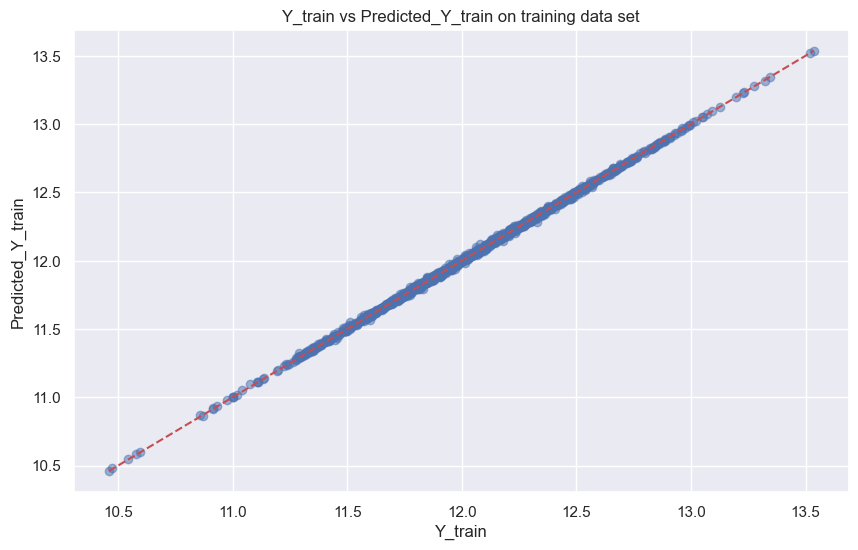

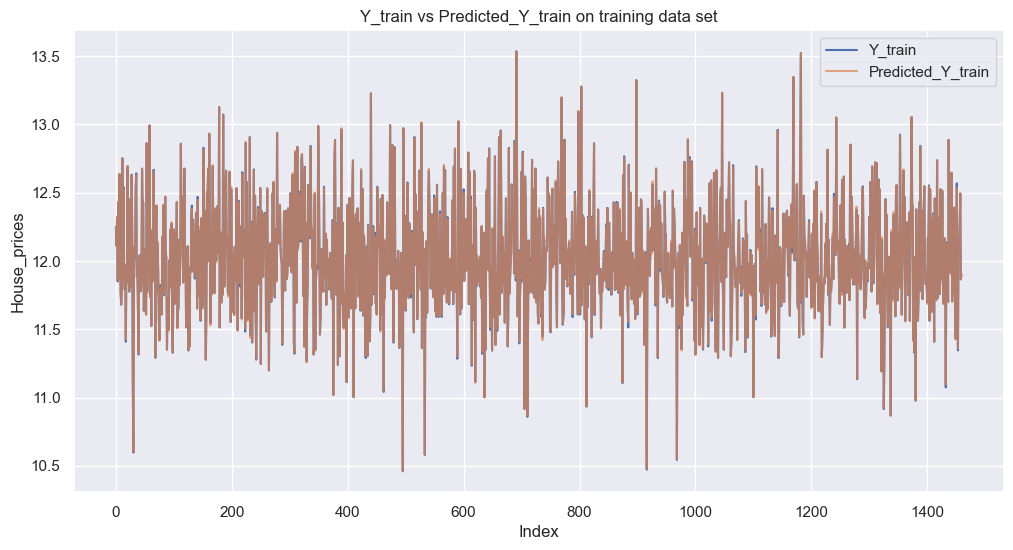

In [58]:
# Scatter plot to compare actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(Y_train, y_pred, alpha=0.5)
plt.xlabel("Y_train")
plt.ylabel("Predicted_Y_train")
plt.title("Y_train vs Predicted_Y_train on training data set")
plt.plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], 'r--')  # Line showing perfect prediction
plt.show()

# Optional: Line plot for comparing actual and predicted values (good for time series data)
plt.figure(figsize=(12, 6))
plt.plot(Y_train.values, label='Y_train')
plt.plot(y_pred, label='Predicted_Y_train', alpha=0.7)
plt.xlabel("Index")
plt.ylabel("House_prices")
plt.title("Y_train vs Predicted_Y_train on training data set")
plt.legend()
plt.show()


# Testing model with test data

In [59]:
test_file = "test.csv"
y_test_inference_file = "sample_submission.csv"

df_test = pd.read_csv(path_to_dataset_folder+"\\"+test_file)

In [60]:
df_test.shape

(1459, 80)

In [61]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [62]:
new_df_test = df_test.copy()

# Preprocess the test data just like the training data. 
i.e, in terms of missing values, eventually normality too

In [63]:
# This will be to handle na_values for LotFrontage
new_df_test["LotFrontage"] = df_test.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

# This will be to handle na_values for MasVnrArea
new_df_test["MasVnrArea"] = new_df_test["MasVnrArea"].fillna(0)

# This will be to handle na_values for Basement
new_df_test["BsmtExposure"] = df_test["BsmtExposure"].fillna(df_test["BsmtExposure"].mode()[0])
new_df_test["BsmtFinType2"] = df_test["BsmtFinType2"].fillna(df_test["BsmtFinType2"].mode()[0])

# # This will be to handle na_values for Electrical
new_df_test["Electrical"] = df_test["Electrical"].fillna(df_test["Electrical"].mode()[0])
# Or to drop the observation
# new_df_train.drop(df_test.loc[df_test['Electrical'].isnull()].index, inplace=True)

In [64]:
new_df_test["PoolQC"] = new_df_test["PoolQC"].fillna("None")

new_df_test["MiscFeature"] = new_df_train["MiscFeature"].fillna("None")

new_df_test["Alley"] = new_df_test["Alley"].fillna("None")

new_df_test["Fence"] = new_df_test["Fence"].fillna("None")

new_df_test["FireplaceQu"] = new_df_test["FireplaceQu"].fillna("None")

new_df_test["MasVnrType"] = new_df_test["MasVnrType"].fillna("None")

In [65]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    new_df_test[col] = new_df_test[col].fillna(0)

In [66]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtFinType1'):
    new_df_test[col] = new_df_test[col].fillna('None')

In [67]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    new_df_test[col] = new_df_test[col].fillna('None')

In [68]:
new_df_test.isnull().sum().max() # just checking that there's no missing data missing...

4

In [69]:
# data transformation
new_df_test['GrLivArea'] = np.log(new_df_test['GrLivArea'])

In [70]:
# create column for new variable (one is enough because it's a binary categorical feature)
# if area>0 it gets 1, for area==0 it gets 0
new_df_test['HasBsmt'] = pd.Series(len(new_df_test['TotalBsmtSF']), index=new_df_test.index)
new_df_test['HasBsmt'] = 0 
new_df_test.loc[new_df_test['TotalBsmtSF']>0,'HasBsmt'] = 1

In [71]:
# transform data
new_df_test.loc[new_df_test['HasBsmt']==1,'TotalBsmtSF'] = np.log(new_df_test['TotalBsmtSF'])

e:\Work\ML\models\ml_practise\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [72]:
df_test_num = df_test.select_dtypes(include = ['float64', 'int64'])
df_test_cat = df_test.select_dtypes(include = ['O'])

In [73]:
columns_to_drop = ['HasBsmt','Id']
categorical_features = list(df_test_cat.columns)
numeric_features = list(df_test_num.columns)

In [74]:
try:
    numeric_features.remove('Id')
except ValueError:
    # Do nothing if Id or SalePrice is not there
    pass

try:
    numeric_features.remove('SalePrice')
except ValueError:
    # Do nothing if SalePrice is not there
    pass

In [75]:
new_df_test.drop(columns=columns_to_drop,axis=1, inplace=True)

In [76]:
X_test = new_df_test
Y_test_df = pd.read_csv(path_to_dataset_folder+"\\"+y_test_inference_file)
Y_test = Y_test_df['SalePrice']
print(X_test.shape, Y_test.shape)


(1459, 79) (1459,)


In [77]:
log_y_pred = pipeline.predict(X_test)

y_pred = np.exp(log_y_pred)
# y_pred = log_y_pred

In [78]:
# Mean Squared Error
test_mse = mean_squared_error(Y_test, y_pred)

# Root Mean Squared Error
test_rmse = np.sqrt(mse)

# Mean Absolute Error
test_mae = mean_absolute_error(Y_test, y_pred)

# R-squared
test_r2 = r2_score(Y_test, y_pred)

print("Mean Squared Error (MSE):", test_mse)
print("Root Mean Squared Error (RMSE):", test_rmse)
print("Mean Absolute Error (MAE):", test_mae)
print("R-squared (R²):", test_r2)


Mean Squared Error (MSE): 5456067322.10555
Root Mean Squared Error (RMSE): 0.008930536964910895
Mean Absolute Error (MAE): 55455.684384761546
R-squared (R²): -19.009978830384124


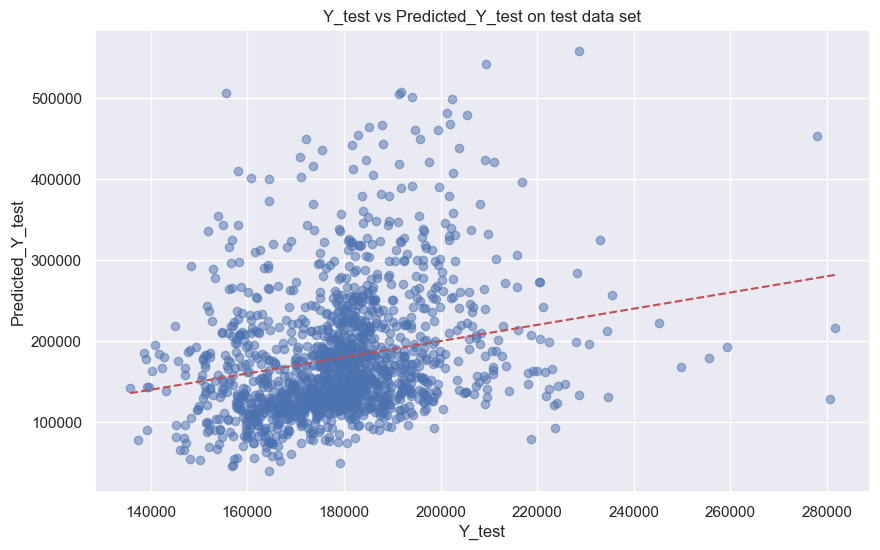

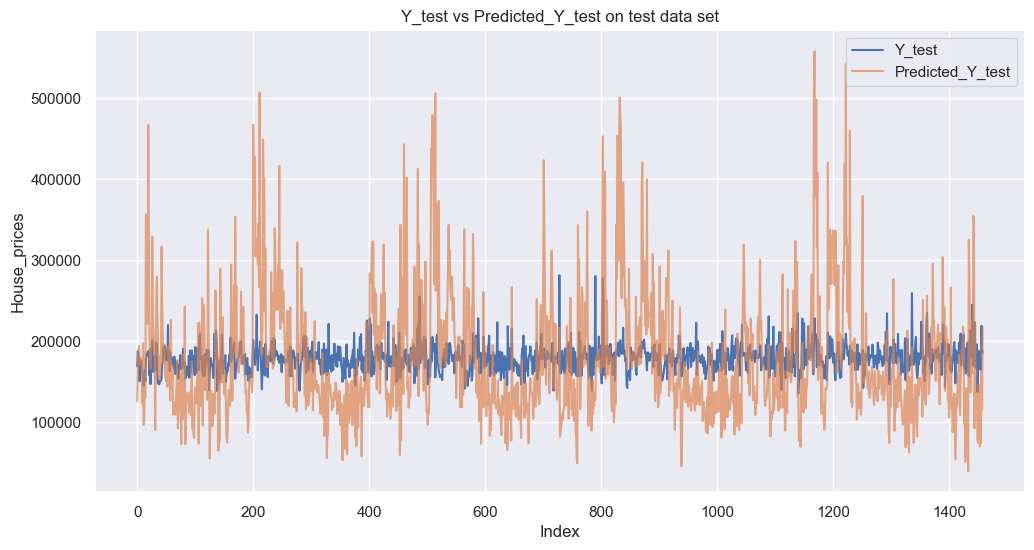

In [79]:
# Scatter plot to compare actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, y_pred, alpha=0.5)
plt.xlabel("Y_test")
plt.ylabel("Predicted_Y_test")
plt.title("Y_test vs Predicted_Y_test on test data set")
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--')  # Line showing perfect prediction
plt.show()

# Optional: Line plot for comparing actual and predicted values (good for time series data)
plt.figure(figsize=(12, 6))
plt.plot(Y_test.values, label='Y_test')
plt.plot(y_pred, label='Predicted_Y_test', alpha=0.7)
plt.xlabel("Index")
plt.ylabel("House_prices")
plt.title("Y_test vs Predicted_Y_test on test data set")
plt.legend()
plt.show()

## THE MLFLOW PART

In [80]:
import mlflow
from mlflow.models import infer_signature
from mlflow.tracking import MlflowClient
from mlflow.deployments import get_deploy_client

In [81]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
metrics = {"mae":mae, "rmse":rmse, "mse":mse,  "r2":r2}
artifact_path = "xgb_model_for_house_pricing"
mlflow_experiment_name = "House Pricing Exp"

The following cell is to create and configure an mlflow experiment

In [82]:
# Create a new MLflow Experiment
mlflow.set_experiment(mlflow_experiment_name)

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(xgb_params)

    # Log the loss metric
    mlflow.log_metrics(metrics)


    # Set a tag that we can use to remind ourselves what this run was for
    # mlflow.set_tag("Staging:", "Prod")

    # Infer the model signature
    signature = infer_signature(X_train, pipeline.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=pipeline,
        artifact_path=artifact_path,
        signature=signature,
        input_example=X_train,
        # registered_model_name="tracking-quickstart",
    )
    
    mlflow.end_run()

2024/08/24 10:08:24 INFO mlflow.tracking.fluent: Experiment with name 'House Pricing Exp' does not exist. Creating a new experiment.
e:\Work\ML\models\ml_practise\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


2024/08/24 10:11:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run nebulous-dove-883 at: http://127.0.0.1:8080/#/experiments/775296615602738054/runs/e06fd25f9fa94e52a39f8689d451928b.
2024/08/24 10:11:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/775296615602738054.


In [113]:
experiment = mlflow.get_experiment_by_name(mlflow_experiment_name)
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
best_rmse = runs['metrics.rmse'].idxmax()
best_run = runs.iloc[best_rmse,:]
registered_model_name = "xgb_model"
result = mlflow.register_model(f"runs:/{best_run.run_id}/model", f"{registered_model_name}")

Successfully registered model 'xgb_model'.
2024/08/24 12:26:57 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: xgb_model, version 1
Created version '1' of model 'xgb_model'.


# Now set tracking to MLAzur workspace